# Task 4: QSVM

This notebook is done by `La Wun Nannda`

> As datasets grow, classical SVMs struggle with real-time or large-scale applications. QSVMs address these limitations by leveraging quantum kernel estimation to map data into complex quantum feature spaces, capturing intricate patterns that classical methods might miss. By exploiting quantum parallelism, QSVMs handle large feature spaces efficiently, enabling faster processing, richer data representations, and improved accuracy and scalability. (Qniverse, n.d.)

## Setup

In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# quantum imports
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

## Loading Dataset

There are three classes in the original Iris dataset:

- **Setosa**: represented by 0
- **Versicolor**: represented by 1
- **Virginica**: represented by 2

By modifying the elements in the `chosen_class` list, any two classes can be selected for a **"binary classification task"**.

In [2]:
# set random seed for reproducibility
np.random.seed(42)

# load the Iris dataset
iris = load_iris()
x = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Before filtering:")
print("  Features (X):", feature_names)
print("  shape:", x.shape)
print()
print("  Unfiltered classes (Y):", target_names)
print("  shape:", y.shape)
print()
print("  Class distribution:", np.bincount(y))
print()

# filter dataset for binary classification
print("After filtering:")
chosen_classes = [0, 2]

mask = (y == chosen_classes[0]) | (y == chosen_classes[1])
x = x[mask]
y = y[mask]
new_target_names = [str(target_names[chosen_classes[0]]), str(target_names[chosen_classes[1]])]
print("  Features (X):", feature_names)
print("  shape:", x.shape)
print()
print("  Filtered classes (Y):", new_target_names)
print("  shape:", y.shape)
print()
print("  Class distribution:", np.bincount(y))

Before filtering:
  Features (X): ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  shape: (150, 4)

  Unfiltered classes (Y): ['setosa' 'versicolor' 'virginica']
  shape: (150,)

  Class distribution: [50 50 50]

After filtering:
  Features (X): ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  shape: (100, 4)

  Filtered classes (Y): ['setosa', 'virginica']
  shape: (100,)

  Class distribution: [50  0 50]


## Preprocessing Dataset

`StandardScaler` is a preprocessing technique that follows the **Standard Normal Distribution (SND)** to standardize each feature by removing the mean (mean = 0) and scaling to unit variance (standard deviation = 1) (Ashwinsharmap, 2025). Although SVMs do not assume normality, they are sensitive to feature scales, so this normalization prevents features with larger values from dominating the model.

For each feature, it applies the following transformation:
$$x\_scaled = \frac{x - μ}{σ}$$

- `x` = original feature value
- `μ` = mean of the feature in the training data
- `σ` = standard deviation of the feature in the training data

The `fit_transform()` method performs two operations on the training dataset:
1. (fit) Calculates and stores the mean and standard deviation for each feature in the training data.
2. (transform) Applies the standardization formula using the mean and standard deviation values.

The `transform()` method performs one operation on the test dataset:
1. (transform) Applies the standardization formula using the same mean and standard deviation values obtained from the training data.

**Notes** 
>**Test data is not fitted**, so the model learns from the training data's distribution (not the test data's distribution) to make predictions on the test data. Moreover, in real-world conditions, only the training data statistics are available.

In [3]:
# split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f"Training dataset shape: {x_train_scaled.shape}")
print(f"Test dataset shape: {x_test_scaled.shape}")

Training dataset shape: (70, 4)
Test dataset shape: (30, 4)


## Quantum Feature Map

A **feature map** is a function that transforms classical data into quantum states that can then be processed by quantum circuits as input data.

1. **PauliFeatureMap**: Uses Pauli-X, Y, and Z gates for encoding (general and simple).
2. **Custom Feature Maps**: User-defined circuits for specific applications (domain-specific and specialized).

***

## Architectural Choice

### 1. ZZFeatureMap2 & ZZFeatureMap3

The `ZZFeatureMap` is a specialized **PauliFeatureMap**. It is chosen because it is well-established in IBM documentation. For this study, two variations are tested with different repetition values (reps=2 and reps=3) to explore the impact of circuit depth on classification performance.

According to IBM (n.d.), it uses the following components:
1. `H`: A Hadamard gate implementing <u>superposition</u> in the computational basis (|0⟩, |1⟩) states.
2. `φ()`: A classical nonlinear function that takes two features (inputs) and returns a scalar value (output), acting as a <u>two-feature functions</u>.
3. `P`: A phase gate with specific scaling, implementing **two-feature functions** as <u>phase-rotations</u> (also known as Z-basis rotations, Pauli-Z rotations, or RZ rotations).
4. `CX`: A controlled-X gate implementing <u>entanglement</u> between qubits, representing **two-qubit interactions**.

These components encode the following:
1. **Single-qubit features**: Features encoded on individual qubits without interactions between qubits.
2. **Two-qubit features**: Features that involve interactions between pairs of qubits, capturing correlations between features.

##### Notes
>- Information is encoded in both the phase (absolute) and the phase differences (relative) between the |0⟩ and |1⟩ states.
>- Different feature values create different phase rotations.
>- The **two-qubit interactions** and **two-feature functions** are the mechanisms that enable the quantum circuit to capture complex feature correlations. As a result, **second-order Pauli-Z evolution** is achieved (hence the term `ZZ`).

***

### 2. XXFeatureMap2 & XXFeatureMap3

The `XXFeatureMap` is not a predefined class in the Qiskit library. Therefore, it is constructed using the **PauliFeatureMap** class, with the paulis parameter set to \['X', 'XX'\] instead of \['Z', 'ZZ'\] (which are the defaults in ZZFeatureMap). For this study, two variations are tested with different repetition values (reps=2 and reps=3) to explore the impact of circuit depth on classification performance.

It uses the following components:
1. `H`: A Hadamard gate implementing <u>superposition</u> in the computational basis (|0⟩, |1⟩) states.
2. `φ()`: A classical nonlinear function that takes two features (inputs) and returns a scalar value (output), acting as a <u>two-feature functions</u>.
3. `P`: A phase gate with specific scaling, implementing **two-feature functions** as <u>amplitude-rotations</u> (also known as X-basis rotations, Pauli-X rotations, or RX rotations).
4. `CX`: A controlled-X gate implementing <u>entanglement</u> between qubits, representing **two-qubit interactions**.

These components encode the following:
1. **Single-qubit features**: Features encoded on individual qubits without interactions between qubits.
2. **Two-qubit features**: Features that involve interactions between pairs of qubits, capturing correlations between features.

##### Notes
>- Information is encoded in both the amplitude (absolute) and the amplitude differences (relative) between the |0⟩ and |1⟩ states.
>- Different feature values create different amplitude rotations.
>- The **two-qubit interactions** and **two-feature functions** are the mechanisms that enable the quantum circuit to capture complex feature correlations. As a result, **second-order Pauli-X evolution** is achieved (hence the term `XX`).

In [4]:
# create quantum feature map
feature_dimension = len(feature_names)

# phase encoding (Z-rotations)
phase_2_reps_feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2)    # Phase, 2 reps
phase_3_reps_feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=3)    # Phase, 3 reps

# amplitude encoding (X-rotations)
amp_2_reps_feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=2, paulis=['X', 'XX'])  # Amplitude, 2 reps
amp_3_reps_feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=3, paulis=['X', 'XX'])  # Amplitude, 3 reps

# group all feature maps
feature_maps = {
    'ZZFeatureMap2': phase_2_reps_feature_map,
    'ZZFeatureMap3': phase_3_reps_feature_map,
    'XXFeatureMap2': amp_2_reps_feature_map,
    'XXFeatureMap3': amp_3_reps_feature_map
}

for name, feature_map in feature_maps.items():
    print(f"Feature map: {name}")
    print(f"  depth: {feature_map.num_qubits}")
    print(f"  parameters: {feature_map.num_parameters}")

Feature map: ZZFeatureMap2
  depth: 4
  parameters: 4
Feature map: ZZFeatureMap3
  depth: 4
  parameters: 4
Feature map: XXFeatureMap2
  depth: 4
  parameters: 4
Feature map: XXFeatureMap3
  depth: 4
  parameters: 4


## Quantum Kernel

The `StatevectorSampler()` method implements the `BaseSamplerV2` interface required by the `ComputeUncompute()` method. It works locally, provides noiseless sampling, and offers simple setup for this learning process.

The `ComputeUncompute()` method creates a fidelity computation strategy using the `Sampler` but does not build circuits yet.

The `FidelityQuantumKernel()` method creates a quantum kernel object that serves as a framework for how to encode data and compute overlaps.

**Notes**
>**Feature transformations**: Sometimes, normalized data is further transformed using a linear or nonlinear function to create a better decision boundary that separates data points into different classes (Visually Explained, 2022).

>**Kernel trick**: Without explicitly computing the transformed features, an SVM can operate in the transformed space using a kernel function (Visually Explained, 2022).

>**Kernel**: A mathematical function that measures the similarity between two transformed data points by taking their inner product in the transformed feature space.
$$K(x, x')=⟨φ(x), φ(x')⟩$$
>- positive values = similarity
>- negative values = dissimilarity  
>- zero = No similarity
Even though the transformation itself may be complex, the expression of the kernel function is usually simple and easy to compute.

>**Quantum kernel**: Transformed data points are represented in a quantum feature space and compared by computing the overlap between their corresponding quantum states. This is achieved by squaring the magnitude of the inner product of two quantum states, giving the **fidelity** (the probability of measuring one state as the other).
$$K(x, x') = |⟨φ(x)|φ(x')⟩|^2$$
>- close to 1 = high similarity
>- close to 0 = low similarity

>**Sampling**: Since quantum computers cannot directly measure inner products, the `Sampler` executes the fidelity circuit multiple times to estimate measurement probabilities from the measurement results. The final probability shows the overlap between two quantum states.
$$\text{P(|0⟩)} = K(x, x')$$
This sampling process happens for each pair of transformed data points and is repeated for all pairs of transformed data points. Each final probability is placed into the quantum kernel matrix.

In [5]:
# create quantum kernel
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)

quantum_kernels = {}
for name, feature_map in feature_maps.items():
    quantum_kernels[name] = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

print("Quantum kernels created successfully")
print()
print(f"Quantum kernels: {quantum_kernels}")

Quantum kernels created successfully

Quantum kernels: {'ZZFeatureMap2': <qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000021B28242A50>, 'ZZFeatureMap3': <qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000021B5DDB5450>, 'XXFeatureMap2': <qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000021B5DDB6D50>, 'XXFeatureMap3': <qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x0000021B5DDB7F90>}


The `evaluate()` method 
- builds fidelity circuits for each pair of transformed data points,
- samples each circuit to obtain the final probability of each pair, and
- constructs the quantum kernel matrix using those probabilities.

In [6]:
# compute each quantum kernel matrix for training data
print("Computing each quantum kernel matrix for training data...")
print()
start_time = time.time()

kernel_matrices_train = {}
for name, quantum_kernel in quantum_kernels.items():
    kernel_matrices_train[name] = quantum_kernel.evaluate(x_train_scaled, x_train_scaled)
    print(f"Kernel matrix name: {name}")
    print(f"  shape: {kernel_matrices_train[name].shape}")
    print(f"  matrix: {kernel_matrices_train[name]}")
    print()

end_time = time.time()
computation_time = end_time - start_time

print(f"Finished in {computation_time:.2f} seconds")

Computing each quantum kernel matrix for training data...

Kernel matrix name: ZZFeatureMap2
  shape: (70, 70)
  matrix: [[1.00013574 0.12307278 0.12404578 ... 0.06834525 0.20117049 0.23337628]
 [0.12307278 1.00000494 0.22266051 ... 0.15527074 0.01581112 0.00957501]
 [0.12404578 0.22266051 1.00000368 ... 0.02441174 0.00601987 0.00960126]
 ...
 [0.06834525 0.15527074 0.02441174 ... 1.00000147 0.05165637 0.0469789 ]
 [0.20117049 0.01581112 0.00601987 ... 0.05165637 1.00700574 0.99282512]
 [0.23337628 0.00957501 0.00960126 ... 0.0469789  0.99282512 1.00734811]]

Kernel matrix name: ZZFeatureMap3
  shape: (70, 70)
  matrix: [[1.00004249 0.19335575 0.0869186  ... 0.03811805 0.38133885 0.36864596]
 [0.19335575 1.00000031 0.08691368 ... 0.13573945 0.15726891 0.14546676]
 [0.0869186  0.08691368 1.00000048 ... 0.04004249 0.04486885 0.03618422]
 ...
 [0.03811805 0.13573945 0.04004249 ... 1.00002427 0.06212434 0.04528606]
 [0.38133885 0.15726891 0.04486885 ... 0.06212434 1.00581518 0.99436248]
 [

## Model Training

Using each quantum kernel matrix, the **Support Vector Classifier** from scikit-learn uses the `SVC()` class to fit the model, finding the optimal hyperplane that separates the classes in the process.

In [7]:
# train SVM with each quantum kernel matrix
print("Training QSVM...")
start_time = time.time()

QSVMs = {}
for name, kernel_matrix_train in kernel_matrices_train.items():
    qsvm = SVC(kernel='precomputed')
    qsvm.fit(kernel_matrix_train, y_train)
    QSVMs[name] = qsvm

end_time = time.time()
computation_time = end_time - start_time

print(f"Finished in {computation_time:.2f} seconds")
print(f"Trained {len(QSVMs)} QSVMs: {list(QSVMs.keys())}")

Training QSVM...
Finished in 0.02 seconds
Trained 4 QSVMs: ['ZZFeatureMap2', 'ZZFeatureMap3', 'XXFeatureMap2', 'XXFeatureMap3']


## Prediction

In [8]:
# compute each quantum kernel matrix for test data
print("Computing each quantum kernel matrix for test data...")
print()
start_time = time.time()

kernel_matrices_test = {}
for name, qsvm in QSVMs.items():
    kernel_matrices_test[name] = quantum_kernel.evaluate(x_test_scaled, x_train_scaled)  # predict on test dataset
    print(f"Kernel matrix name: {name}")
    print(f"  shape: {kernel_matrices_train[name].shape}")
    print(f"  matrix: {kernel_matrices_train[name]}")
    print()

end_time = time.time()
computation_time = end_time - start_time

print(f"Finished in {computation_time:.2f} seconds")

Computing each quantum kernel matrix for test data...

Kernel matrix name: ZZFeatureMap2
  shape: (70, 70)
  matrix: [[1.00013574 0.12307278 0.12404578 ... 0.06834525 0.20117049 0.23337628]
 [0.12307278 1.00000494 0.22266051 ... 0.15527074 0.01581112 0.00957501]
 [0.12404578 0.22266051 1.00000368 ... 0.02441174 0.00601987 0.00960126]
 ...
 [0.06834525 0.15527074 0.02441174 ... 1.00000147 0.05165637 0.0469789 ]
 [0.20117049 0.01581112 0.00601987 ... 0.05165637 1.00700574 0.99282512]
 [0.23337628 0.00957501 0.00960126 ... 0.0469789  0.99282512 1.00734811]]

Kernel matrix name: ZZFeatureMap3
  shape: (70, 70)
  matrix: [[1.00004249 0.19335575 0.0869186  ... 0.03811805 0.38133885 0.36864596]
 [0.19335575 1.00000031 0.08691368 ... 0.13573945 0.15726891 0.14546676]
 [0.0869186  0.08691368 1.00000048 ... 0.04004249 0.04486885 0.03618422]
 ...
 [0.03811805 0.13573945 0.04004249 ... 1.00002427 0.06212434 0.04528606]
 [0.38133885 0.15726891 0.04486885 ... 0.06212434 1.00581518 0.99436248]
 [0.36

In [9]:
# make predictions
print("Making predictions...")
start_time = time.time()

y_hats = {}  # predictions
for name, qsvm in QSVMs.items():
    y_hats[name] = qsvm.predict(kernel_matrices_test[name])  # predict on test dataset

end_time = time.time()
computation_time = end_time - start_time

print(f"Finished in {computation_time:.2f} seconds")
print(f"Predictions repeated for {len(y_hats)} times")

Making predictions...
Finished in 0.00 seconds
Predictions repeated for 4 times


## Evaluation
### Classification Report


- **Precision** measures how precise the model is when it makes positive predictions.
    - (Correct positive prediction) The positive predictions match the actual positive class.

- **Recall** measures how much of the actual positive class the model correctly predicted.
    - (Correct proportion) The proportion of the actual positive class that is correctly predicted.

- **F1-Score** is the harmonic mean of precision and recall, balancing both prediction quality and completeness.

- **Support** is the number of actual instances of each class in the test dataset.
    - (Actual count)

- **Accuracy** measures how accurate the model is overall.
    - (Correct total prediction) The proportion of all predictions that are correct compared to the total number of predictions made.

**Notes**
> Since SVMs do not train iteratively, tracking training progress is not applicable.

In [10]:
# initialize comparison dataframe
comparison_df = pd.DataFrame({
    'Feature Map': list(QSVMs.keys())
})
comparison_df.set_index('Feature Map', inplace=True)

In [11]:
# classification report
accuracies = {}
for name, y_hat in y_hats.items():
    print(f"{name}: {y_hat}")
    print()
    print(classification_report(y_test, y_hat, target_names=new_target_names))
    accuracies[name] = accuracy_score(y_test, y_hat)
    print("=" * 80)

    # add accuracy to dataframe
    comparison_df.loc[name, 'Accuracy'] = accuracies[name]

ZZFeatureMap2: [0 2 2 0 0 0 2 2 0 0 2 0 2 0 2 0 0 0 0 0 2 0 2 2 2 0 2 2 2 2]

              precision    recall  f1-score   support

      setosa       0.73      0.65      0.69        17
   virginica       0.60      0.69      0.64        13

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.68      0.67      0.67        30

ZZFeatureMap3: [0 2 2 0 0 0 2 2 0 0 2 0 0 0 2 0 0 0 0 0 2 0 2 0 2 2 0 2 0 2]

              precision    recall  f1-score   support

      setosa       0.72      0.76      0.74        17
   virginica       0.67      0.62      0.64        13

    accuracy                           0.70        30
   macro avg       0.69      0.69      0.69        30
weighted avg       0.70      0.70      0.70        30

XXFeatureMap2: [2 0 2 0 0 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 2 0 2]

              precision    recall  f1-score   support

      setosa       0.70      0.82      0.76        17
   

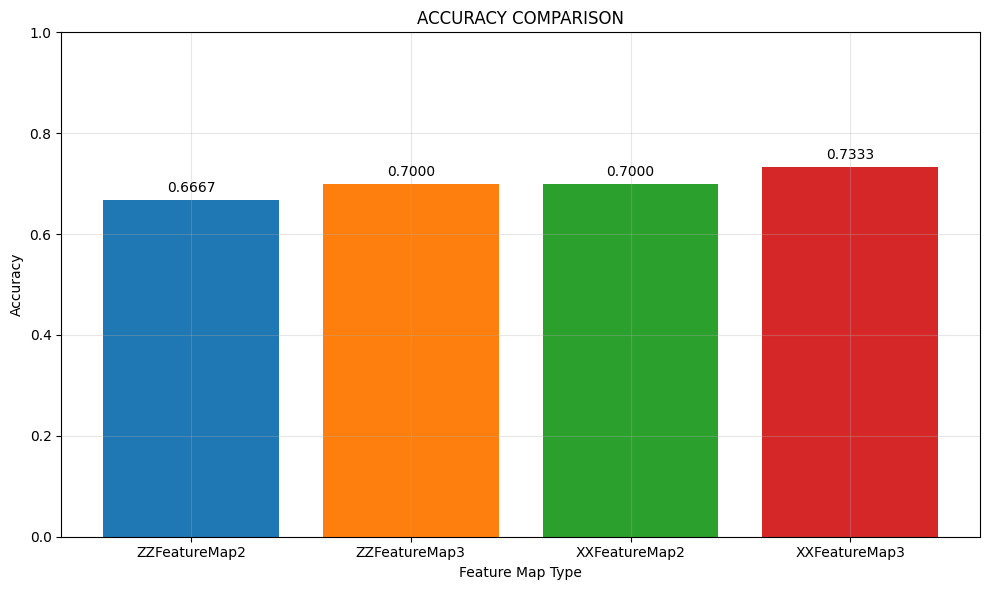

In [12]:
# create bar plot of accuracies
plt.figure(figsize=(10, 6))
names = comparison_df['Accuracy'].index.tolist()
values = comparison_df['Accuracy'].tolist()

bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Feature Map Type')
plt.ylabel('Accuracy')
plt.title('ACCURACY COMPARISON')
plt.ylim(0, 1)

# add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Hinge Loss

The hinge loss is a commonly used loss function for SVMs. It penalizes predictions that are either incorrect or not confident enough, particularly in binary classification tasks (Rahulsm27, 2025).

$$L(y, f(x)) = max(0, m - y * f(x))$$
- `y` = actual class
- `f(x)` = output of the classifier for the datapoint
- `m` = margin (standard is 1.0)

Computing the hinge loss provides insights into the model:
- lower hinge loss = more confident, correct predictions
    - `0.0-0.3`: strong confidence
    - `0.3-0.7`: moderate confidence
- higher hinge loss = less confident, incorrect predictions
    - `0.7-1.0`: low confidence
    - `1.0+`: incorrect predictions or low margin
- training hinge loss < test hinge loss → possible overfitting
- training hinge loss ≈ test hinge loss → generalization is good
- training hinge loss > test hinge loss → possible underfitting

(Alok, 2024)

**Notes**
>For <u>one-class</u> classification (e.g., anomaly detection):
>- class1 true: +1 (prediction is class1; answer is class1)
>- class1 false: -1 (prediction is class1; answer is not class1)

>For <u>binary</u> classification (e.g., class1 vs. class2):
>- class1 true: +1 (prediction is class1; answer is class1)
>- class1 false: -1 (prediction is class1; answer is class2)

>For <u>multi-class one-vs-rest</u> classification (e.g., class1 vs. class2 vs. class3 vs. ...):
>- class1 true: +1 (prediction is class1; answer is class1)
>- class1 false: -1 (prediction is class1; answer is class2 OR class3 OR ...)

In this approach, binary classification is applied.

In [13]:
# function to compute hinge loss
def compute_hinge_loss(y_true, y_pred_scores, margin=1.0):  # margin = 1.0 is a standard choice
    losses = []
    classes = np.unique(y_true)

    for cls in classes:
        # get ONE specific class
        y_binary = np.where(y_true == cls, 1, -1)

        if y_pred_scores.ndim == 1:  # for binary classification
            scores = y_pred_scores  # use all scores directly
        else:  # for multi-class classification
            scores = y_pred_scores[:, cls]  # extract scores for that class
        
        # compute hinge loss
        loss = np.maximum(0, margin - y_binary * scores)
        losses.append(np.mean(loss))
    
    return np.mean(losses)

In [14]:
# compute hinge loss for training and test datasets for each QSVM
hinge_losses = {}
for name, qsvm in QSVMs.items():
    # get decision function scores    
    y_scores_train = qsvm.decision_function(kernel_matrices_train[name])
    y_scores_test = qsvm.decision_function(kernel_matrices_test[name])
    
    # compute hinge loss
    train_loss = compute_hinge_loss(y_train, y_scores_train, margin=1)
    test_loss = compute_hinge_loss(y_test, y_scores_test, margin=1)
    
    hinge_losses[name] = {'train': train_loss, 'test': test_loss}
    
    print(f"{name}:")
    print(f"  Training Hinge Loss: {train_loss:.4f}")
    print(f"  Test Hinge Loss: {test_loss:.4f}")
    print()
    
    # add hinge losses to dataframe
    comparison_df.loc[name, 'Train Loss'] = train_loss
    comparison_df.loc[name, 'Test Loss'] = test_loss

ZZFeatureMap2:
  Training Hinge Loss: 1.0001
  Test Hinge Loss: 1.0052

ZZFeatureMap3:
  Training Hinge Loss: 1.0014
  Test Hinge Loss: 1.0581

XXFeatureMap2:
  Training Hinge Loss: 1.0109
  Test Hinge Loss: 1.0120

XXFeatureMap3:
  Training Hinge Loss: 1.0008
  Test Hinge Loss: 1.0042



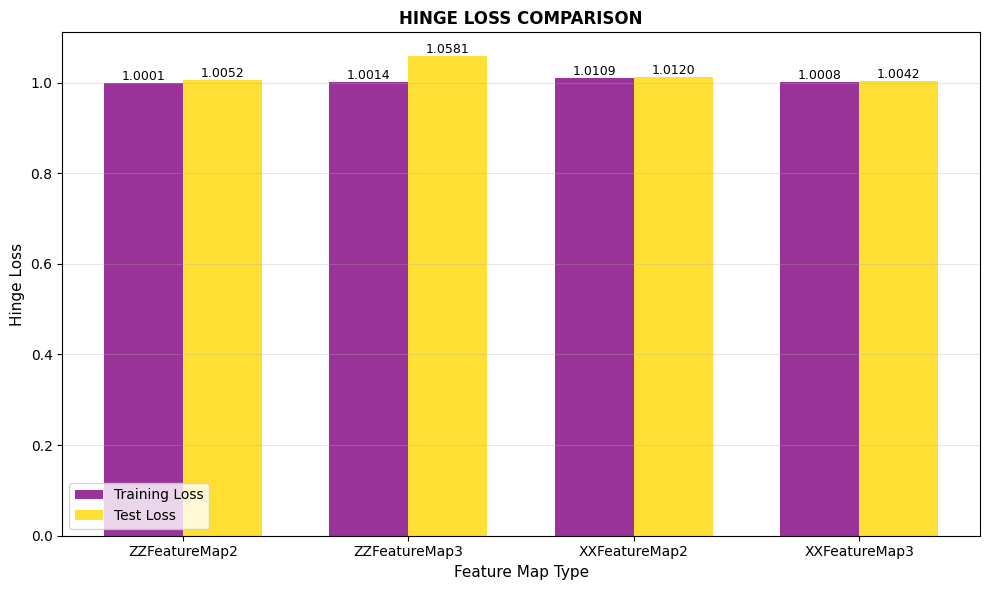

In [15]:
# create bar plot for hinge loss with two bars for each of the 4 feature maps
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(4)  # 4 feature maps: ZZ2, ZZ3, XX2, XX3
width = 0.35

# get values
train_losses = comparison_df['Train Loss'].values
test_losses = comparison_df['Test Loss'].values

bars1 = ax.bar(x - width/2, train_losses, width, label='Training Loss', 
               color='purple', alpha=0.8)
bars2 = ax.bar(x + width/2, test_losses, width, label='Test Loss', 
               color='gold', alpha=0.8)

ax.set_xlabel('Feature Map Type', fontsize=11)
ax.set_ylabel('Hinge Loss', fontsize=11)
ax.set_title('HINGE LOSS COMPARISON', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# add value labels on bars
for bar, value in zip(bars1, train_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}', ha='center', va='bottom', fontsize=9)

for bar, value in zip(bars2, test_losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Confusion Matrix

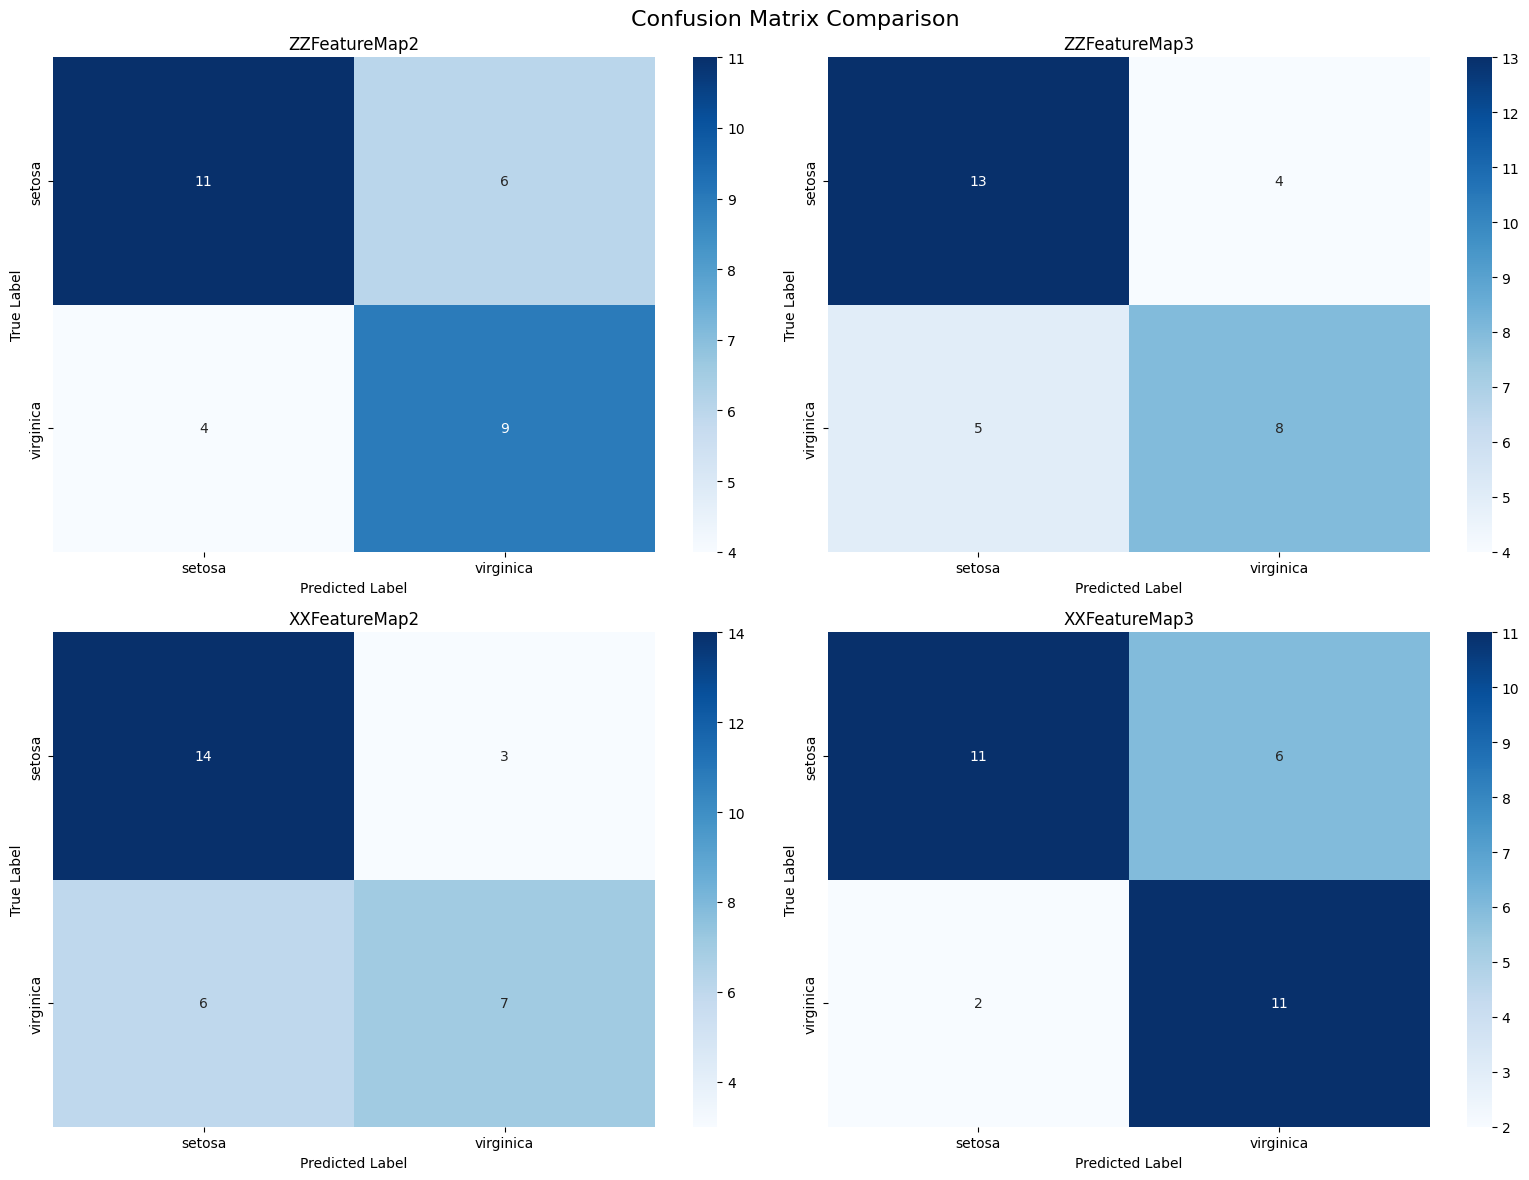

In [16]:
# confusion matrices for all QSVMs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (name, y_hat) in enumerate(y_hats.items()):
    # create
    cm = confusion_matrix(y_test, y_hat)
    
    # plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=new_target_names, yticklabels=new_target_names,
                ax=axes[i])
    axes[i].set_title(f'{name}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

fig.suptitle('Confusion Matrix Comparison', fontsize=16)
plt.tight_layout()
plt.show()

### Expressibility Analysis

The `decompose()` method decomposes the circuit to obtain the actual gates (IBM, n.d.).

In [17]:
# analyze circuit expressibility
for name, feature_map in feature_maps.items():
    print(f"{name}:")
    print(f"  Number of qubits: {feature_map.num_qubits}")
    print(f"  Repetitions (reps): {feature_map.reps}")
    print(f"  Number of parameters: {feature_map.num_parameters}")
    print(f"  Entanglement pattern: {feature_map.entanglement}")

    decomposed = feature_map.decompose()

    print(f"  Circuit depth: {decomposed.depth()}")
    print(f"  Total gates: {decomposed.size()}")
    print(f"  Gate count breakdown: {decomposed.count_ops()}")
    print()

    # add expressibility metrics to dataframe
    comparison_df.loc[name, 'Qubits'] = feature_map.num_qubits
    comparison_df.loc[name, 'Reps'] = feature_map.reps
    comparison_df.loc[name, 'Params'] = feature_map.num_parameters
    comparison_df.loc[name, 'Entanglement'] = feature_map.entanglement
    comparison_df.loc[name, 'Depth'] = decomposed.depth()
    comparison_df.loc[name, 'Total Gates'] = decomposed.size()

ZZFeatureMap2:
  Number of qubits: 4
  Repetitions (reps): 2
  Number of parameters: 4
  Entanglement pattern: full
  Circuit depth: 31
  Total gates: 52
  Gate count breakdown: OrderedDict([('cx', 24), ('p', 20), ('h', 8)])

ZZFeatureMap3:
  Number of qubits: 4
  Repetitions (reps): 3
  Number of parameters: 4
  Entanglement pattern: full
  Circuit depth: 45
  Total gates: 78
  Gate count breakdown: OrderedDict([('cx', 36), ('p', 30), ('h', 12)])

XXFeatureMap2:
  Number of qubits: 4
  Repetitions (reps): 2
  Number of parameters: 4
  Entanglement pattern: full
  Circuit depth: 53
  Total gates: 116
  Gate count breakdown: OrderedDict([('h', 72), ('cx', 24), ('p', 20)])

XXFeatureMap3:
  Number of qubits: 4
  Repetitions (reps): 3
  Number of parameters: 4
  Entanglement pattern: full
  Circuit depth: 77
  Total gates: 174
  Gate count breakdown: OrderedDict([('h', 108), ('cx', 36), ('p', 30)])



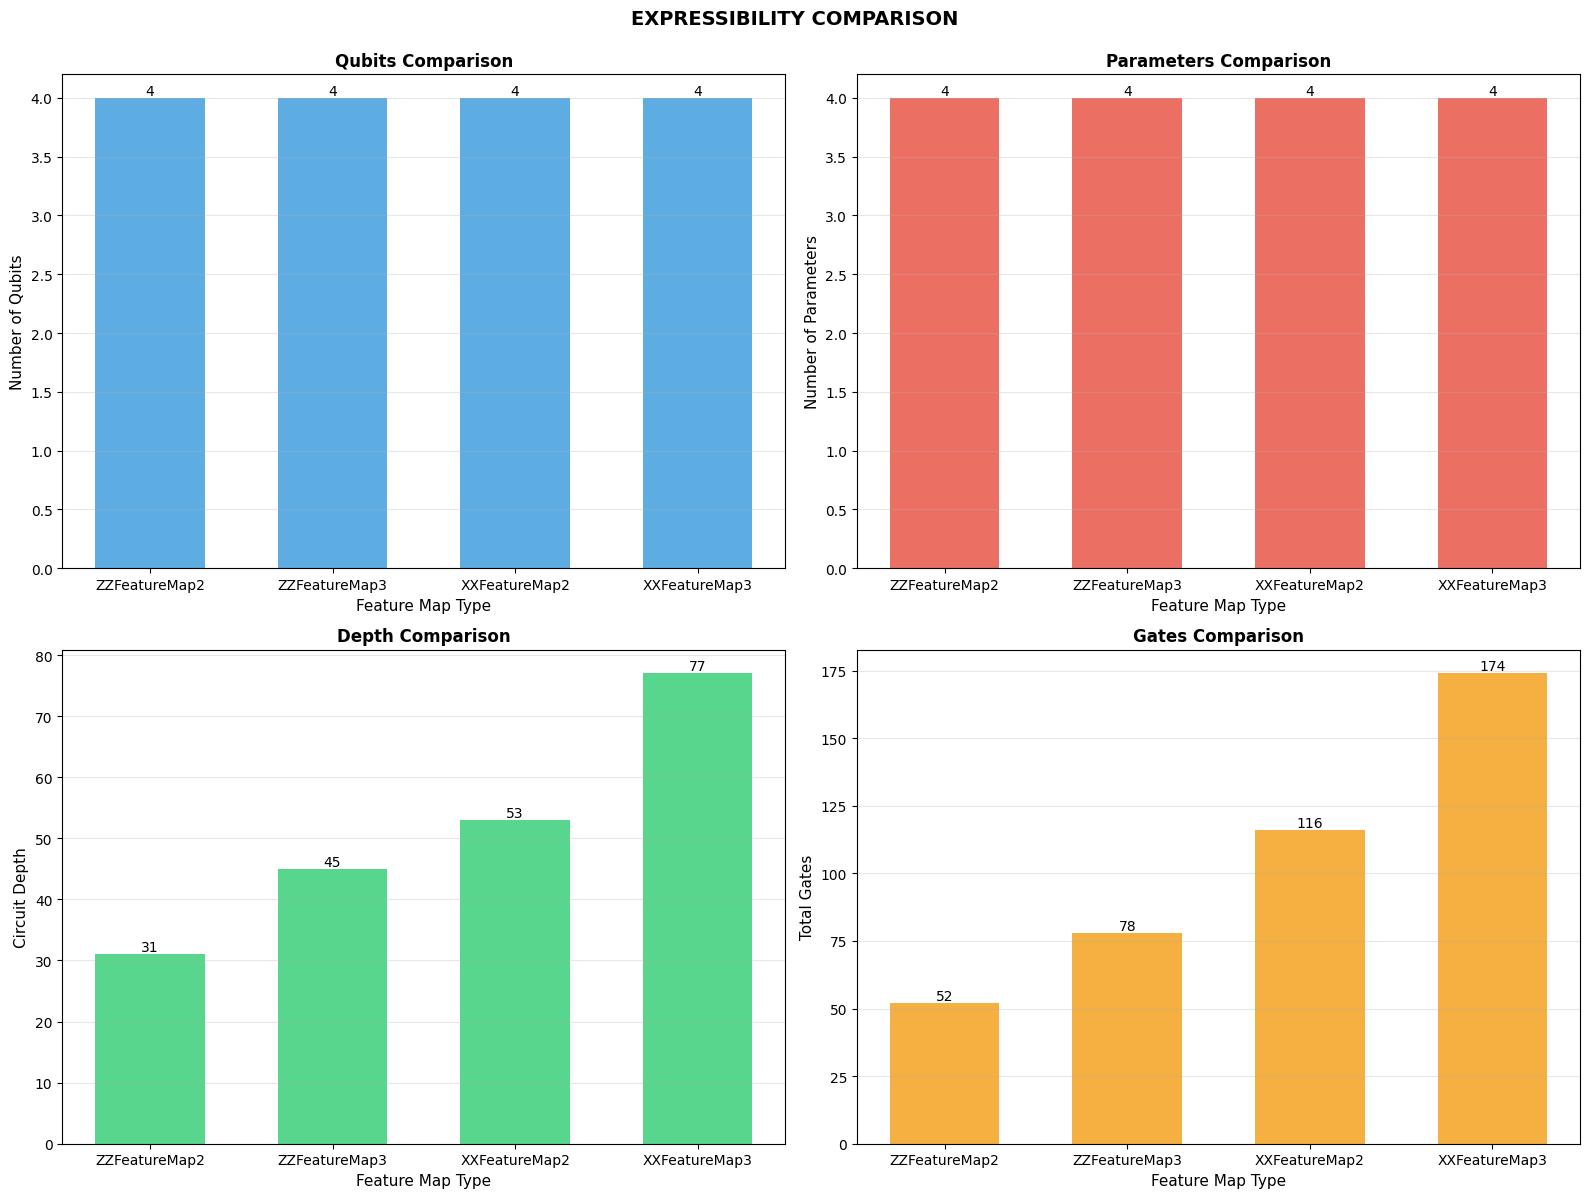

In [18]:
# create four bar plots for expressibility metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

x = np.arange(4)  # 4 feature maps
width = 0.6

# 1. Number of qubits
bars1 = axes[0].bar(x, comparison_df['Qubits'].values, width, 
                    color='#3498db', alpha=0.8)
axes[0].set_xlabel('Feature Map Type', fontsize=11)
axes[0].set_ylabel('Number of Qubits', fontsize=11)
axes[0].set_title('Qubits Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# add value labels
for bar, value in zip(bars1, comparison_df['Qubits'].values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(value)}', ha='center', va='bottom', fontsize=10)

# 2. Number of parameters
bars2 = axes[1].bar(x, comparison_df['Params'].values, width, 
                    color='#e74c3c', alpha=0.8)
axes[1].set_xlabel('Feature Map Type', fontsize=11)
axes[1].set_ylabel('Number of Parameters', fontsize=11)
axes[1].set_title('Parameters Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# add value labels
for bar, value in zip(bars2, comparison_df['Params'].values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(value)}', ha='center', va='bottom', fontsize=10)

# 3. Circuit depth
bars3 = axes[2].bar(x, comparison_df['Depth'].values, width, 
                    color='#2ecc71', alpha=0.8)
axes[2].set_xlabel('Feature Map Type', fontsize=11)
axes[2].set_ylabel('Circuit Depth', fontsize=11)
axes[2].set_title('Depth Comparison', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='y')

# add value labels
for bar, value in zip(bars3, comparison_df['Depth'].values):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(value)}', ha='center', va='bottom', fontsize=10)

# 4. Total gates
bars4 = axes[3].bar(x, comparison_df['Total Gates'].values, width, 
                    color='#f39c12', alpha=0.8)
axes[3].set_xlabel('Feature Map Type', fontsize=11)
axes[3].set_ylabel('Total Gates', fontsize=11)
axes[3].set_title('Gates Comparison', fontsize=12, fontweight='bold')
axes[3].set_xticks(x)
axes[3].set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=10)
axes[3].grid(True, alpha=0.3, axis='y')

# add value labels
for bar, value in zip(bars4, comparison_df['Total Gates'].values):
    height = bar.get_height()
    axes[3].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(value)}', ha='center', va='bottom', fontsize=10)

plt.suptitle('EXPRESSIBILITY COMPARISON', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [19]:
# verify comparison dataframe
comparison_df

,Accuracy,Train Loss,Test Loss,Qubits,Reps,Params,Entanglement,Depth,Total Gates
Feature Map,,,,,,,,,
ZZFeatureMap2,0.666667,1.000083,1.005247,4.0,2.0,4.0,full,31.0,52.0
ZZFeatureMap3,0.700000,1.001395,1.058068,4.0,3.0,4.0,full,45.0,78.0
XXFeatureMap2,0.700000,1.010929,1.012045,4.0,2.0,4.0,full,53.0,116.0
XXFeatureMap3,0.733333,1.000849,1.004175,4.0,3.0,4.0,full,77.0,174.0


## Conclusion

Given that all approaches use full entanglement with the same number of parameters and qubits, the following findings emerge:

### 1. Performance

Amplitude encoding (XXFeatureMap) achieves higher accuracy compared to phase encoding (ZZFeatureMap) approaches.

### 2. Expressibility

For feature maps of the same encoding, those with higher repetitions have more depth, and therefore higher expressibility, allowing them to represent more complex functions.

Feature maps using amplitude encoding (XXFeatureMap) have significantly higher depth and total gates than feature maps that use phase encoding (ZZFeatureMap), which increases expressibility but also complexity and potential noise sensitivity.

### 3. Practicality

Phase encoding (ZZFeatureMap) circuits scale better because they require fewer gates for the similar accuracy values.

### 4. Final Conclusion

Phase encoding balances efficiency and performance in general and scales well, but there is a chance of underfitting some complex boundaries due to lower expressibility. On real hardware, noise accumulates, and therefore amplitude encoding approaches may increase error susceptibility on real hardware due to deeper circuits and larger gate counts.

# References
- Alok, Y. (2024, December 23). *What is hinge loss in machine learning?* Analytics Vidhya. [link](https://www.analyticsvidhya.com/blog/2024/12/hinge-loss-in-machine-learning/)
- Ashwinsharmap. (2025, July 12). *StandardScaler, MinMaxScaler and RobustScaler techniques - ML*. GeeksforGeeks. [link](https://www.geeksforgeeks.org/machine-learning/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/)
- IBM. (n.d.). *PauliFeatureMap*. IBM Quantum Platform. [link](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.PauliFeatureMap)
- IBM. (n.d.). *ZZFeatureMap*. IBM Quantum Platform. [link](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.ZZFeatureMap)
- Karar, D. (2024, September 14). *Quantum support vector machines (QSVM) using qiskit*. Medium. [link](https://medium.com/@devmallyakarar/quantum-support-vector-machines-qsvm-using-qiskit-eee347e81d83)
- Qniverse. (n.d.). QSVM. [link](https://qniverse.in/docs/qsvm/)
- Rahulsm27. (2025, August 21). *Hinge-loss & relationship with support vector machines*. GeeksforGeeks. [link](https://www.geeksforgeeks.org/machine-learning/hinge-loss-relationship-with-support-vector-machines/)
- Sahagian, G. (2020, November 30). *What is random state? And why is it always 42?* Medium. [link](https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b)
- Visually Explained. (2022, May 9). *The kernel trick in support vector machine (SVM)* \[Video\]. YouTube. [link](https://youtu.be/Q7vT0--5VII)